In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from gPhoton.galextools import mag2counts

In [2]:
# Import the function definitions that accompany this notebook tutorial.
nb_funcdef_file = "function_defs.py"
if os.path.isfile(nb_funcdef_file):
    from function_defs import get_inff, calculate_flare_energy, refine_flare_ranges
else:
    raise IOError("Could not find function definition file '" + nb_funcdef_file + "' that goes with this notebook.")

In [3]:
# Import the function definitions that accompany this notebook tutorial.
nb_recoverydef_file = "recovery_defs.py"
if os.path.isfile(nb_recoverydef_file):
    from recovery_defs import fake_a_flare, calculate_ideal_flare_energy, inject_and_recover
else:
    raise IOError("Could not find recovery definition file '" + nb_recoverydef_file + "' that goes with this notebook.")

In [4]:
# Restore the distance parameter.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the distance to use.
%store -r distance
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the distance to the system in parsecs.
#distance = 1/(372.1631/1000) # parsecs

In [5]:
# Define some parameters for our recovery tests.
band = 'NUV'
binsize = 30.
quiescent_mag = 18. # approx. NUV mag of UV Ceti
trange = [0., 1600.] # nominal GALEX visit start and end, in seconds
resolution = 0.05 # photon time resolution in seconds
detection_threshold = 3. # min. detection threshold allowed for a flare to be considered "detected", measured in sigma
random_seed = 42 # So that the exact results here when selecting random flare properties are repeatable.
np.random.seed(random_seed)

Let's generate some synthetic flares and compare the energies measured by our flare finding algorithm with the known
values.

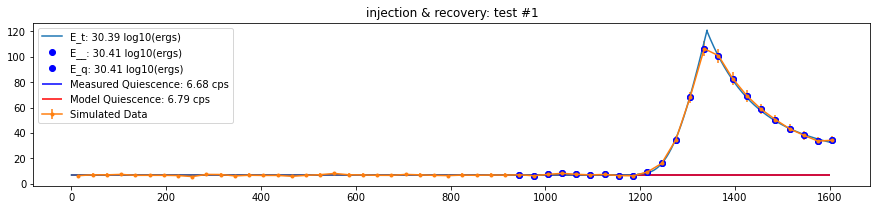

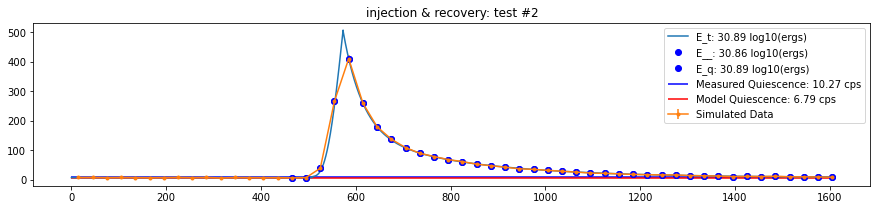

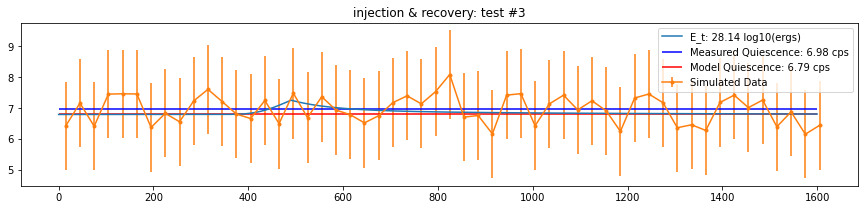

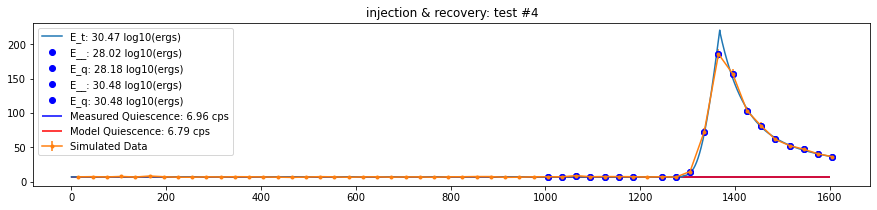

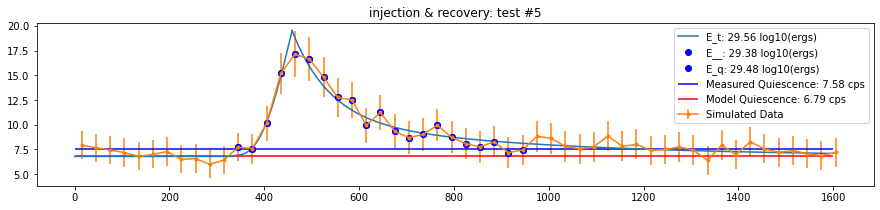

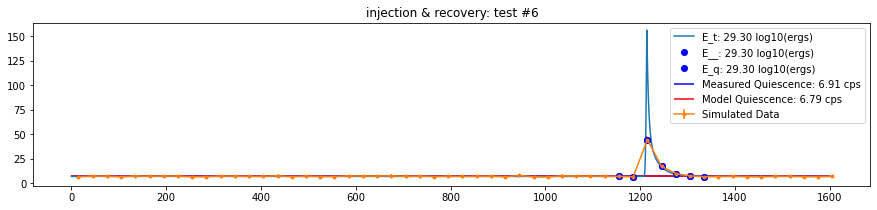

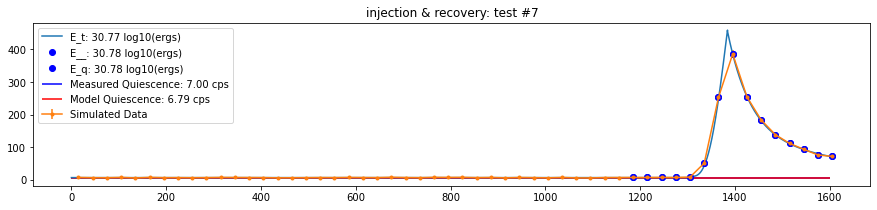

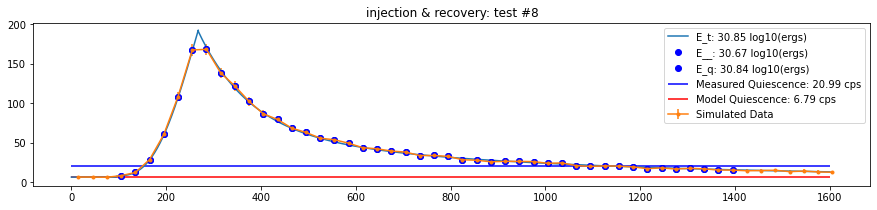

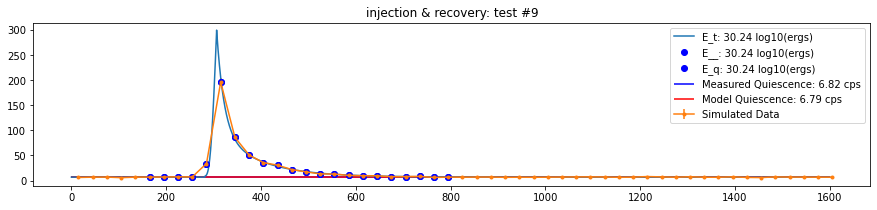

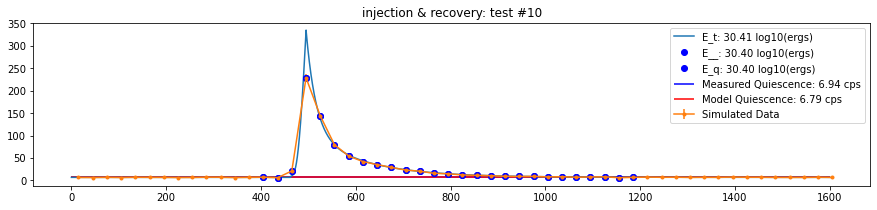

In [6]:
n_flares_to_make = 10
for i in range(n_flares_to_make):
    # Generate a flare with random properties within plausible ranges.
    # First: select a peak NUV magnitude from within a specified range.
    fpeak_mag = np.random.uniform(low=13, high=18)
    # Have the flare start at some random time during the visit (avoid edges since we don't count truncated flares in
    # the paper analysis either.
    tpeak = np.random.uniform(low=trange[0]+200, high=trange[1]-200)
    # Now assign the flare a random full width at half maximum (FWHM).
    fwidth = np.random.uniform(low=1, high=200)
    # Generate the model flare.
    model, lc = fake_a_flare(band=band, quiescent_mag=quiescent_mag, fpeak_mag=fpeak_mag,
        stepsz=binsize, trange=trange, tpeak=tpeak, fwidth=fwidth, resolution=resolution)

    # Calculate the energy of this synthetic flare.
    model_energy = calculate_ideal_flare_energy(model, mag2counts(quiescent_mag, band), distance)
    
    # Determine the INFF based on the light curve generated.
    q, q_err = get_inff(lc)
    
    # Locate the flare range following the algorithm described in our paper.
    fr, quiescence, quiescence_err = refine_flare_ranges(lc, sigma=detection_threshold, makeplot=False)

    plt.figure(figsize=(15, 3))
    plt.title('injection & recovery: test #{i}'.format(i=i+1))
    plt.plot(model['t0']+resolution/2., model['cps'], '-',
             label='E_t: {:.2f} log10(ergs)'.format(np.log10(model_energy)))
    plt.errorbar(lc['t0']+binsize/2., lc['cps'],
        yerr=detection_threshold*lc['cps_err'], fmt='.-', label='Simulated Data')
    plt.hlines(q, model['t0'].min(), model['t1'].max(),
                label='Measured Quiescence: {:.2f} cps'.format(q), color='b')
    plt.hlines(mag2counts(18, band), model['t0'].min(),model['t1'].max(),
                label='Model Quiescence: {:.2f} cps'.format(mag2counts(quiescent_mag,band)),color='r')
    for f in fr:
        energy = calculate_flare_energy(lc, f, distance, band=band)
        # Note: no "uncertainty" needed in our quiescence measurement, so that's why the argument has "0.0" since
        # the function expects this to be passed as a two-element list containing q and q_err.
        energy_w_q = calculate_flare_energy(lc, f, distance, band=band,
                                            quiescence=[mag2counts(quiescent_mag, band), 0.0])
        plt.plot(lc.iloc[np.unique(f)]['t0']+binsize/2.,
                 lc.iloc[np.unique(f)]['cps'],'bo',label='E__: {:.2f} log10(ergs)'.format(np.log10(energy[0])))
        plt.plot(lc.iloc[np.unique(f)]['t0']+binsize/2.,
                 lc.iloc[np.unique(f)]['cps'],'bo',label='E_q: {:.2f} log10(ergs)'.format(np.log10(energy_w_q[0])))
    plt.legend()

Now let's see what the absolute smallest and largest flares detected are following the paper's algorithm, running 100,000 synthetic flares and rejecting those that are truncated as incomplete by the flare finding algorithm. NOTE: This can take some time to run (a few hours on a laptop).  Since it does take so long, we save the output the first time you run this notebook using the `%store` magick.  After you run this cell once, you can set the "redo" variable to False and you won't have to run this again each time you run this notebook on the same sample of flares.

In [7]:
redo = False
if redo:
    output = inject_and_recover(n=100000, omit_incompletes=True)
    %store output
else:
    %store -r output
emin, emax = np.array(output['energy_true']).min(), np.array(output['energy_true']).max()
print("Min. and Max. Energy Flares Detected: " + str(emin) + ', ' + str(emax))

Min. and Max. Energy Flares Detected: 4.338013765936807e+24, 3.2574333992400974e+31


Let's see how well the flare energies are measured from the flare detection algorithm that includes an estimate of the INFF, compared to the energies measured with the (known) quiescent value. This tests the ability of the flare detection algorithm to derive accurate flare energies after estimating the quiescent value by comparing the flare energies derived with the perfect knowledge of what the simulated quiescent value is.

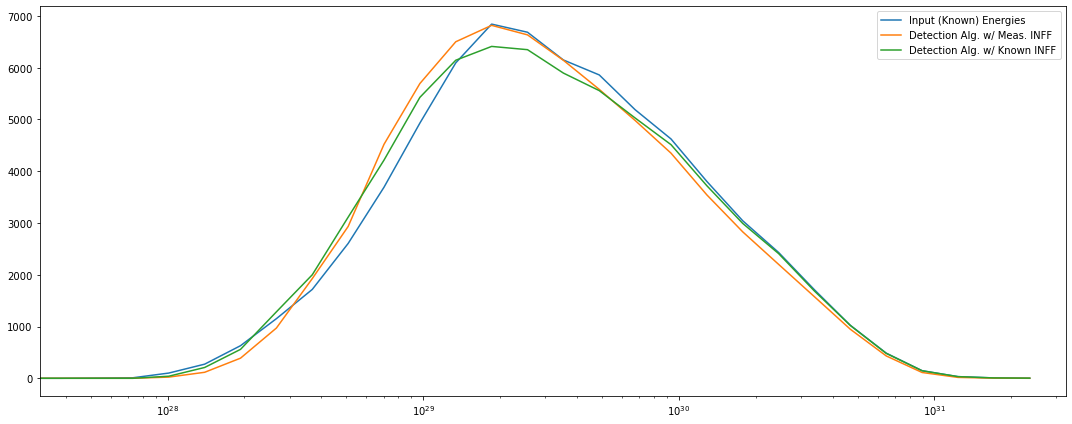

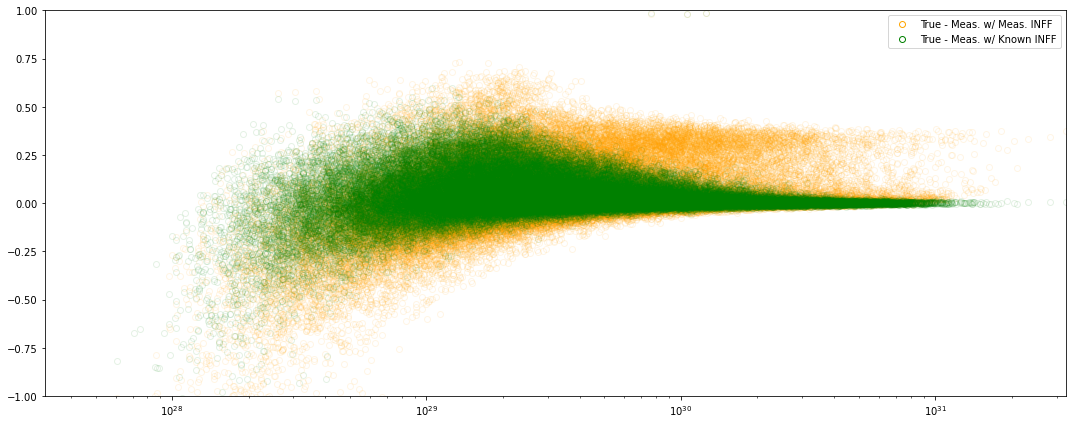

Percent of measured energies (w/ INFF meas.) within 50% of the input =  98.19%
Percent of meas. energies (w/ INFF meas.) where 28 < log(E) < 29, within 50% of the input =  92.42%


In [8]:
# Divide the flare range into energy bins in log space.
bins = np.logspace(np.log10(emin), np.log10(emax), 50)

# We don't include any flares that didn't have an energy measured at all.
ix = np.where(np.array(output['energy_measured']) != 0)[0]

# Histogram of true (input) flare energies.
true_hist, _ = np.histogram(np.asarray(output['energy_true'][ix]), bins=bins)
# Histogram of measured flare energies allowing the flare detection to determine INFF.
meas_hist, _ = np.histogram(np.asarray(output['energy_measured'][ix]), bins=bins)
# Histogram of measured flare energies fixing the INFF to the known (input) quiescent level.
meas_hist_with_q, _ = np.histogram(np.asarray(output['energy_measured_w_q'][ix]), bins=bins)

# Let's make a plot showing these distributions and the difference with and without perfect knowledge of the
# INFF/quiescent value.
fig1 = plt.figure(figsize=(15,6))
plt.plot(bins[:-1], true_hist, label='Input (Known) Energies')
plt.plot(bins[:-1], meas_hist, label='Detection Alg. w/ Meas. INFF')
plt.plot(bins[:-1], meas_hist_with_q, label='Detection Alg. w/ Known INFF')
plt.semilogx()
# Nothing is detected below 10^27.5, so let's zoom in on the x-axis.
plt.xlim([10**27.5, emax])
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()

# Let's look at the differences between the two energy measurements and the intput energies.
fig2 = plt.figure(figsize=(15, 6))

# Plot the differences between input energy and measured energies with and without known INFF values.
plt.plot(output['energy_true'][ix],
         (output['energy_true'][ix] - output['energy_measured'][ix])/output['energy_true'][ix], 'o',
         fillstyle='none', label="True - Meas. w/ Meas. INFF", color='orange', alpha=0.1)
plt.plot(output['energy_true'][ix],
         (output['energy_true'][ix] - output['energy_measured_w_q'][ix])/output['energy_true'][ix], 'o',
         fillstyle='none', label="True - Meas. w/ Known INFF", color='green', alpha=0.1)
plt.semilogx()
# Nothing is detected below 10^27.5, so let's zoom in on the x-axis.
plt.xlim([10**27.5, emax])
# There are a very small number that differ by factors of a few, but hardly any, so let's zoom in on +/- 100%.
plt.ylim(-1., 1.)
plt.tight_layout()
leg = plt.legend(loc="upper right")
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
plt.show()

# Let's determine how many are within +/- 50% of the input energy, since the goal here is to DETECT the flare, not
# necessarily measure the correct energy (uncertainties are measured and reported.)  This is because our energy bins
# are large (powers of ten), so a factor of ~2 in measured energy will not significantly impact the FFD when they are
# binned at the level of powers of 10.
n_factor_two = len(np.where(
    abs((np.asarray(output['energy_true'][ix]) - np.asarray(output['energy_measured'][ix]))/
        np.asarray(output['energy_true'][ix]))
                        <= 0.50)[0])
print("Percent of measured energies (w/ INFF meas.) within 50% of the input = {0:6.2f}%".format(
    n_factor_two / float(len(output['energy_true'][ix])) * 100.))

# Let's examine how this ratio is for flares with energies between 10**28 to 10**29, since that's where the bulk
# of the detected GJ 65 flares reside.
n_factor_two_lowe = len(np.where(
    (np.asarray(abs((output['energy_true'][ix] - output['energy_measured'][ix])/
         output['energy_true'][ix])) <= 0.50) &
    (np.asarray(output['energy_true'][ix]) >= 10**28) &
    (np.asarray(output['energy_true'][ix]) <= 10**29)
                                )[0])
n_28_29 = len(np.where(
    (np.asarray(output['energy_true'][ix]) >= 10**28) &
    (np.asarray(output['energy_true'][ix]) <= 10**29)
                      )[0])
print("Percent of meas. energies (w/ INFF meas.) where 28 < log(E) < 29, within 50% of the input = {0:6.2f}%".format(
      n_factor_two_lowe / float(n_28_29) * 100.))

Now let's check what fraction of the flares are detected by our algorithm (regardless of the derived energy, because we know practically all of them are within 50% of the input energy, and that is good enough for our purposes.)

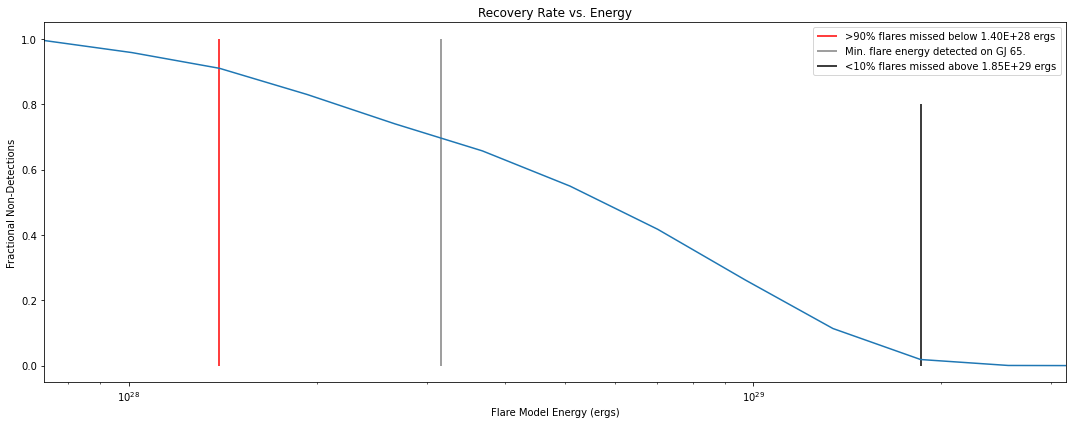

Fraction of flares missed at log(E) = 28.5:  69.94%
Fraction of flares missed at log(E) = 29:  25.04%
Fraction of flares missed at log(E) = 29.5:   0.02%


In [9]:
# For this plot, we DO want to include simulated flares that we did NOT detect, so we won't filter out those
# non-detected flares with the "ix" mask.
true_hist, _ = np.histogram(np.asarray(output['energy_true']), bins=bins)

# Find all the flares where the energy was NOT measured, because the flare wasn't detected.
ix = np.where(np.array(output['energy_measured']) == 0)
# Compute the histogram across the bins.
non_hist, non_bins = np.histogram(np.array(output['energy_true'])[ix], bins=bins)
# What fraction out of the total did we miss in each bin?
fractional_nondetection = non_hist/true_hist

# Make a plot of the histogram of fractional non-detections with 10-90% recovery limits.
plt.figure(figsize=(15, 6))
plt.title('Recovery Rate vs. Energy')

# Plot of the number missed per energy bin.
plt.plot(non_bins[:-1], fractional_nondetection)

# What is the highest energy bin where we recover only ~10% of the flares?
p_gt_90 = non_bins[np.where(fractional_nondetection > 0.90)[0][-1]]

plt.vlines(non_bins[np.where(fractional_nondetection > 0.90)[0][-1]], 0, 1,
        label='>90% flares missed below {:.2E} ergs'.format(p_gt_90), color='red')

# Overplot the lowest-energy flare we find on GJ 65.
plt.vlines(10**28.5, 0, 1, label='Min. flare energy detected on GJ 65.', color='grey')

# What is the lowest energy bin where we recover up to 90% of the flares?
p_lt_10 = non_bins[np.where(fractional_nondetection < 0.10)[0][0]]

plt.vlines(non_bins[np.where(fractional_nondetection < 0.1)[0][0]], 0, 0.8,
        label='<10% flares missed above {:.2E} ergs'.format(p_lt_10))
plt.semilogx()
plt.ylabel('Fractional Non-Detections')
plt.xlabel('Flare Model Energy (ergs)')
# Let's trim out the extreme low-energy bins where absolutely everything is missed.
# Upper x-axis plot range extends to upper limit of the energy bin in our paper: 28.5 < log(E) < 29.5
plt.xlim([non_bins[np.where(fractional_nondetection > 0.99)[0][-1]],
          10**29.5])
plt.tight_layout()
plt.legend()
plt.show()

# What is the number of flares with non-detections at the low-end of the bin used in the GJ 65 FFD calculation?
p_at_285 = np.interp(10**28.5, bins[:-1], fractional_nondetection)
print("Fraction of flares missed at log(E) = 28.5: {0:6.2f}%".format(p_at_285*100.))

# What is the number of flares with non-detections at the middle of the bin used in the GJ 65 FFD calculation?
p_at_29 = np.interp(10**29, bins[:-1], fractional_nondetection)
print("Fraction of flares missed at log(E) = 29: {0:6.2f}%".format(p_at_29*100.))

# What is the number of flares with non-detections at the high-end of the bin used in the GJ 65 FFD calculation?
p_at_295 = np.interp(10**29.5, bins[:-1], fractional_nondetection)
print("Fraction of flares missed at log(E) = 29.5: {0:6.2f}%".format(p_at_295*100.))